# 基本配置

In [1]:
import utils
import numpy as np

import cnn
import time
import ssptm

# 数据集
dataset_dict = {
    # (%, dim): (0.999, 69) (0.99, 25) (0.95, 5)
    'Indian_Pines': {
        'shape': [145, 145],
        'dim': 200,
        'num_class': 16 + 1,
        'data_path': './datasets/IndianPines/Indian_pines_corrected.mat',
        'data_name': 'indian_pines_corrected',
        'label_path': './datasets/IndianPines/Indian_pines_gt.mat',
        'label_name': 'indian_pines_gt',
        'T': 162
    },
    # (%, dim): (0.999, 16) (0.99, 4) (0.95, 3)
    'Pavia_University': {
        'shape': [610, 340],
        'dim': 103,
        'num_class': 9 + 1,
        'data_path': './datasets/PaviaUniversity/PaviaU.mat',
        'data_name': 'paviaU',
        'label_path': './datasets/PaviaUniversity/PaviaU_gt.mat',
        'label_name': 'paviaU_gt',
        'T': 132
    },
    # (%, dim): (0.999, 6) (0.99, 3) (0.95, 2)
    'Salinas_Scene': {
        'shape': [512, 217],
        'dim': 204,
        'num_class': 16 + 1,
        'data_path': './datasets/SalinasScene/Salinas_corrected.mat',
        'data_name': 'salinas_corrected',
        'label_path': './datasets/SalinasScene/Salinas_gt.mat',
        'label_name': 'salinas_gt',
        'T': 102
        # 'T': 51

    },
}

In [2]:
# 噪声水平
noise_ratio = 0.3

# 扩散学习相关参数
pca_dim = 16  # PCA降维维度
dirty_ratio = 0.3  # unlabelled数据所占比例
alpha = 0.75  # 扩散程度

# cnn训练参数
batch_size = 4096

epoch_test = 50
lr_test = 0.0001

epochs_1 = 10
lr_1 = 0.0001

epochs_2 = 15
lr_2 = 0.0001

# 加载数据集并预处理

In [3]:
test_dataset = 'Salinas_Scene'
print("\n> 加载数据集并预处理...")
dataset = dataset_dict[test_dataset]
data, label = utils.load_dataset(dataset['data_path'], dataset['data_name'], dataset['label_path'],
                                 dataset['label_name'])

# 预处理
processed_data, one_hot_label, superpixels = utils.preprocess(data, label, dataset['num_class'], pca_dim,
                                                              dataset['T'])

# 提取出样本块
extracted_data, one_hot_label, superpixels = utils.extract_samples(processed_data, one_hot_label, superpixels,
                                                                   window_size=9, dataset_size=0.15)


> 加载数据集并预处理...


# 测试模型本身在数据集上的性能

In [4]:
# 测试模型本身在正确数据集上的性能：
# print("\n> 测试模型本身在正确数据集上的性能...")
# cnn._test(extracted_data, one_hot_label, pca_dim, dataset['num_class'],
#           test_size=0.3, epochs=epoch_test,
#           lr=lr_test, batch_size=batch_size, save_model=False)

# 生成带有噪声的数据集并划分


> 构造带有噪声的数据集[ratio=0.3]...


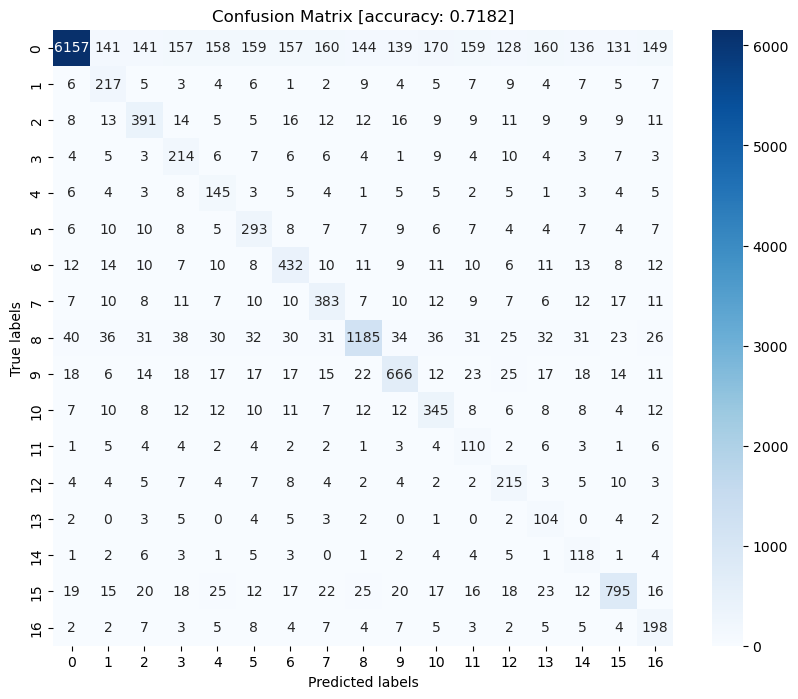

> The accuracy of labels with noise: 
------------------------------
Accuracy: 0.7181518151815182
Average Accuracy: 0.7193259355663668
Kappa: 0.6390244977954673
------------------------------


In [5]:
print(f"\n> 构造带有噪声的数据集[ratio={noise_ratio}]...")
# 向标签中增加噪声
noisy_label = utils.add_noise_to_label(one_hot_label, noise_ratio)

# 查看当前标签的正确率
evaluation_list = utils.evaluate(one_hot_label, noisy_label, noise_ratio=noise_ratio, save=False)
utils.print_evaluation(evaluation_list, '> The accuracy of labels with noise: ')

# 划分数据集(带有脏标签)
clean_data, dirty_data, clean_label, dirty_label, mask = utils.split_dataset(extracted_data, noisy_label,
                                                                             dirty_ratio)

# 初始化训练模型

In [6]:
# 训练模型
print("\n> 模型初始化训练中...")
model = cnn.train(clean_data, clean_label, pca_dim, dataset['num_class'], batch_size=batch_size, epochs=epochs_1,
                  lr=lr_1, save_model=False)


> 模型初始化训练中...
Epoch [1/10], Train Loss: 2.2945
Epoch [2/10], Train Loss: 1.7398
Epoch [3/10], Train Loss: 1.5949
Epoch [4/10], Train Loss: 1.4992
Epoch [5/10], Train Loss: 1.4411
Epoch [6/10], Train Loss: 1.3962
Epoch [7/10], Train Loss: 1.3446
Epoch [8/10], Train Loss: 1.2869
Epoch [9/10], Train Loss: 1.2348
Epoch [10/10], Train Loss: 1.1673


# 提取特征

In [7]:
# 提取特征
print("\n> 提取特征中...")
# 可以采用直接加载模型的方式，注释掉上述的训练模型部分
# model = './models/cnn_last.pth'
model, feature_data = cnn.feature_extract(model, extracted_data, pca_dim, dataset['num_class'])


> 提取特征中...


# 标签传播 - 构建SSPTM

In [8]:
# 标签传播过程
print("\n> 标签传播:")
# 构建SSPTM
print("构建SSPTM...")
A = ssptm.sparse_affinity_matrix(feature_data, superpixels)
SSPTM = ssptm.generate_SSPTM(A)
# 计算最大值
max_val = np.max(A)

# 计算最小值
min_val = np.min(A)

# 计算均值
mean_val = np.mean(A)

# 计算中位数
median_val = np.median(A)

print("最大值:", max_val)
print("最小值:", min_val)
print("均值:", mean_val)
print("中位数:", median_val)


> 标签传播:
构建SSPTM...
计算了超像素
最大值: 1.0
最小值: 0.0
均值: 0.008121902835042756
中位数: 0.0


# 预测伪标签并评价

预测伪标签...
Time taken[CG]: 59.687652826309204 seconds


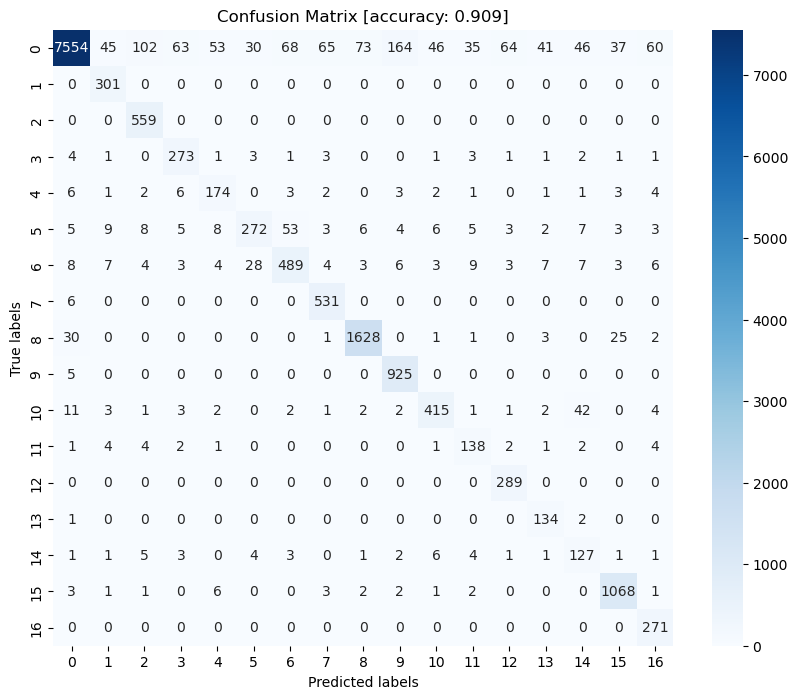

> 直接以伪标签作为结果:
------------------------------
Accuracy: 0.908970897089709
Average Accuracy: 0.9139725675461358
Kappa: 0.876845924235794
------------------------------


In [9]:
# 预测伪标签
print("预测伪标签...")
remove_noise_label = utils.gen_label_for_propagation(noisy_label, mask)
pseudo_label, cg_solution, info = utils.diffusion_learning(SSPTM, remove_noise_label, alpha=alpha, verbose=False)

evaluation_list = utils.evaluate(one_hot_label, pseudo_label, noise_ratio=noise_ratio, save=False)
utils.print_evaluation(evaluation_list, '> 直接以伪标签作为结果:')

# 模型二阶段训练


> 模型第二阶段训练...
Epoch [1/15], Train Loss: 0.5853
Epoch [2/15], Train Loss: 0.4637
Epoch [3/15], Train Loss: 0.3957
Epoch [4/15], Train Loss: 0.3377
Epoch [5/15], Train Loss: 0.2936
Epoch [6/15], Train Loss: 0.3131
Epoch [7/15], Train Loss: 0.2979
Epoch [8/15], Train Loss: 0.2730
Epoch [9/15], Train Loss: 0.2625
Epoch [10/15], Train Loss: 0.2526
Epoch [11/15], Train Loss: 0.2204
Epoch [12/15], Train Loss: 0.2051
Epoch [13/15], Train Loss: 0.1898
Epoch [14/15], Train Loss: 0.1781
Epoch [15/15], Train Loss: 0.1678


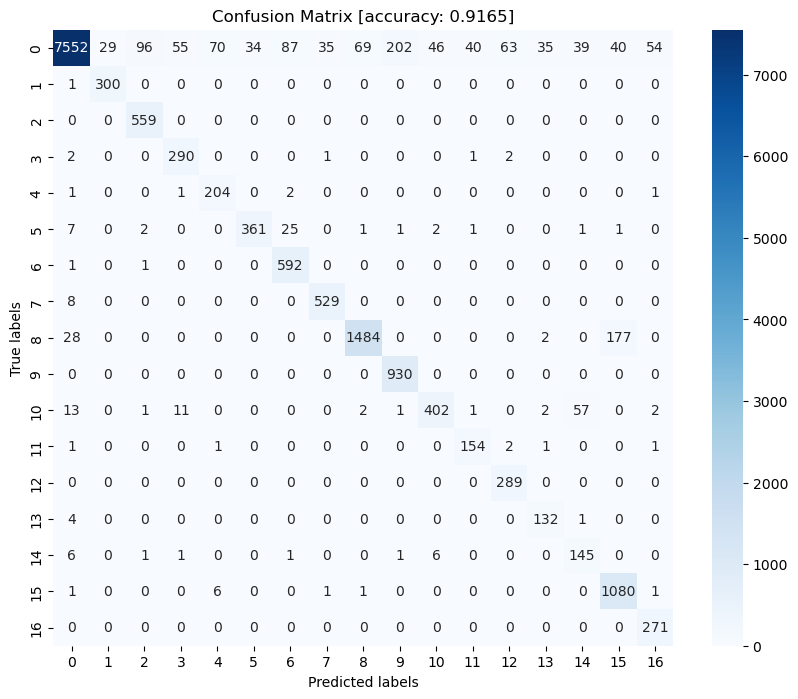

> 二阶段模型在整个数据集上的评价结果:
------------------------------
Accuracy: 0.9165316531653165
Average Accuracy: 0.954589913030473
Kappa: 0.8871582891392968
------------------------------


In [10]:
print("\n> 模型第二阶段训练...")
model = cnn.train_2(model, extracted_data, pseudo_label, epochs=epochs_2, lr=lr_2, batch_size=batch_size,
                    save_model=False)
# 可以直接加载训练两次后的模型来进行预测，需要只是掉提取样本块后的代码
# model = cnn.load_model_eval(model_path, pca_dim, dataset['num_class'])
result_label = cnn.cls(model, extracted_data, batch_size=batch_size)
evaluation_list = utils.evaluate(one_hot_label, result_label, noise_ratio=noise_ratio, save=False)
utils.print_evaluation(evaluation_list, '> 二阶段模型在整个数据集上的评价结果:')

In [48]:
# 为每个伪标签增加权重

# 对样本类别预测概率值进行归一化
normalized_cg_solution = cg_solution / cg_solution.sum(axis=1)[:, np.newaxis]
# 计算熵值
eps = 1e-10  # 添加一个小的常数，避免log(0)的情况
entropies = -np.sum(normalized_cg_solution * np.log(normalized_cg_solution + eps), axis=1)
# 归一化熵值
max_entropy = np.log(normalized_cg_solution.shape[-1])
normalized_entropies = entropies / max_entropy
weights_sample = 1-normalized_entropies

In [49]:
weights_sample

array([0.48667139, 0.67606019, 0.45573356, ..., 0.57846335, 0.65670643,
       0.53917778])

In [50]:
# 为每个伪类增加权重
class_counts = np.sum(pseudo_label, axis=0)
weights_class = 1 / class_counts
# 归一化权重
weights_class = weights_class / np.sum(weights_class)

In [51]:
weights_class

array([0.00313924, 0.0642577 , 0.03493896, 0.06695006, 0.09625752,
       0.07112203, 0.03872072, 0.03909971, 0.01397558, 0.02163188,
       0.0497264 , 0.12044283, 0.0658465 , 0.12418716, 0.10155985,
       0.02100624, 0.0671376 ], dtype=float32)